['are_or_not', 'is', 'is_near', 'is_not', 'is_surrounded_by']
self.do_is_surrounded_by('pit','breeze','pit is_surrounded_by breeze')
self.do_is_surrounded_by('wumpus','stench','wumpus is_surrounded_by stench')
self.do_is_surrounded_by('gold','spark','gold is_surrounded_by spark')
self.do_is_near('breeze','pit','breeze is_near pit')
self.do_is_near('stench','wumpus','stench is_near wumpus')
self.do_is_near('spark','gold','spark is_near gold')
self.do_is_not('safe','wumpus','safe is_not wumpus')
self.do_is_not('safe','pit','safe is_not pit')
self.do_is_not('wumpus','pit','wumpus is_not pit')
self.do_is_not('wumpus','gold','wumpus is_not gold')
self.do_is_not('pit','wumpus','pit is_not wumpus')
self.do_is_not('pit','gold','pit is_not gold')
self.do_is_not('gold','wumpus','gold is_not wumpus')
self.do_is_not('gold','pit','gold is_not pit')
self.do_are_or_not('wumpus|pit','safe','wumpus|pit are_or_not safe')
agent移动至(0, 0),分数-1,此地有


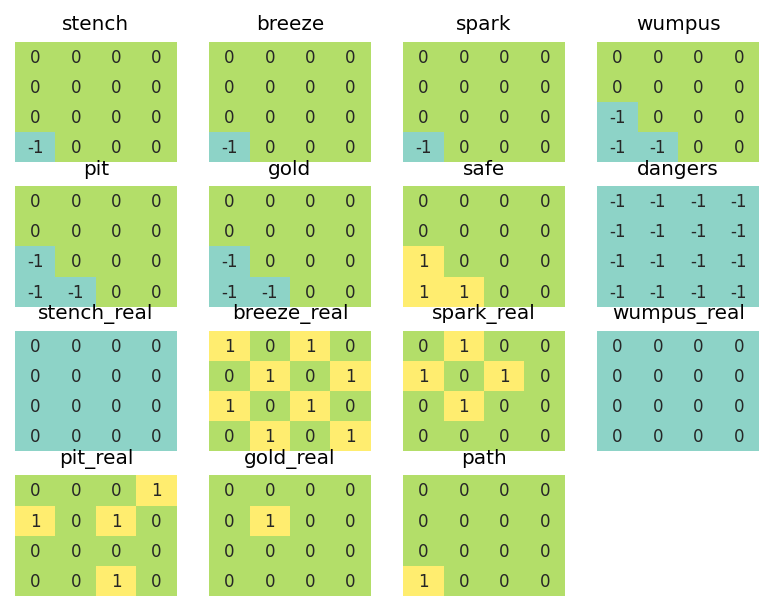

01的safe为1
01的dangers为-1
10的safe为1
10的dangers为-1
agent移动至(0, 1),分数-2,此地有breeze


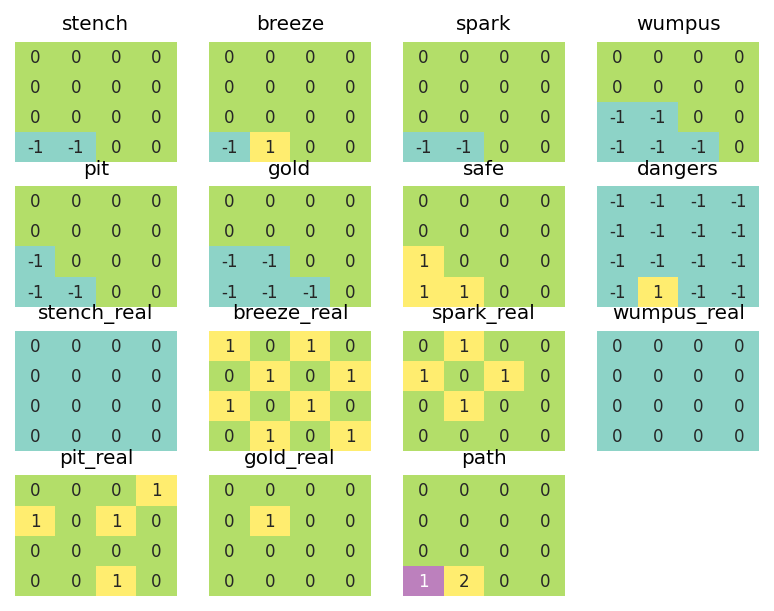

10的safe为1
10的dangers为-1
无法判断02的safe
无法判断11的safe
agent移动至(1, 0),分数-3,此地有breeze


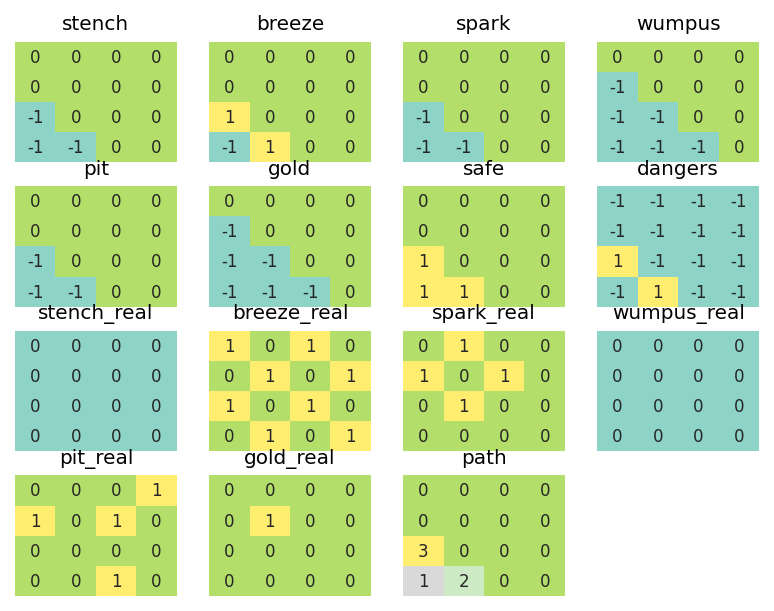

无法判断02的safe
无法判断11的safe
无法判断20的safe
agent移动至(2, 0),分数-104,此地有spark,pit


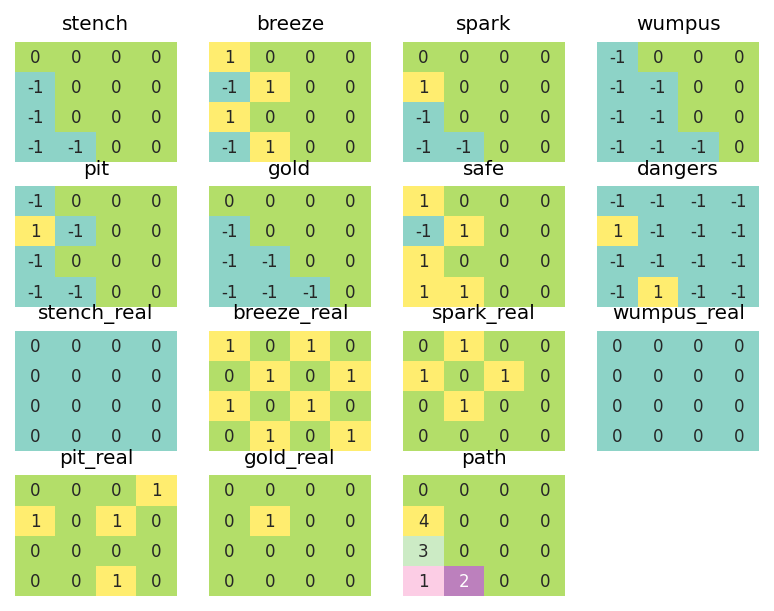

无法判断02的safe
无法判断11的safe
21的safe为1
21的dangers为-1
30的safe为1
30的dangers为-1
agent移动至(2, 1),分数895,此地有breeze,gold


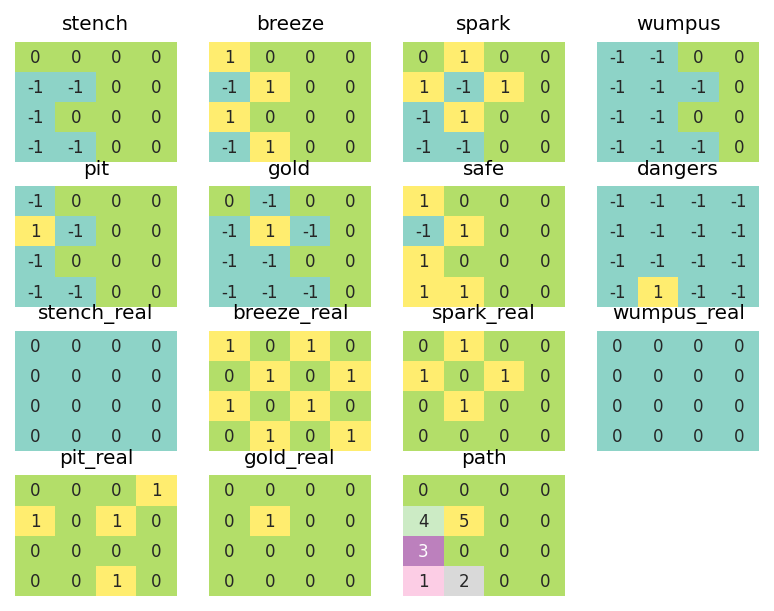

无法判断02的safe
无法判断11的safe
30的safe为1
30的dangers为-1
无法判断22的safe
无法判断31的safe
agent移动至(3, 0),分数894,此地有breeze


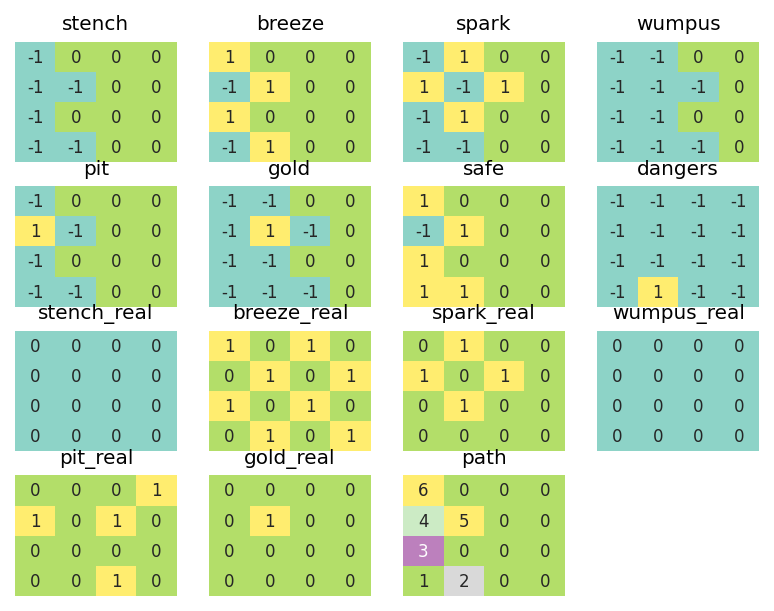

In [4]:
import random

import numpy as np
import pandas as pd
import inspect
import matplotlib.pyplot as plt
import seaborn as sns

class Thing:
    def __init__(self, name=''):
        self.name = name
    def __repr__(self):
        return self.name

class Rule(Thing):
    def __init__(self, name=''):
        self.name = name
    def update(self, loc):
        pass
    def check(self, loc):
        pass
    def node_nearby(self, lx, ly, loc):
        (x0, y0) = loc
        rs_xy = []
        for x, y in [(x0, y0 - 1), (x0, y0 + 1), (x0 - 1, y0), (x0 + 1, y0)]:
            if x >= 0 and x < lx and y >= 0 and y < ly:
                rs_xy.append((x, y))
        return rs_xy

class RuleSurrounded(Rule):
    def __init__(self, kb, a, b, name=''):
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 0:
                    self.b[x][y] = 1
                    self.kb.add_update_if_not_exists((x0, y0))
                elif self.b[x][y] == -1:
                    print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.a[x][y] == 1:
                    return False
        return True

class RuleIsNear(Rule):
    def __init__(self, kb, a, b, name=''):
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            found = False
            not_sure_nodes = []
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 1:
                    found = 1
                elif self.b[x][y] == 0:
                    not_sure_nodes.append((x, y))
            if not found:
                if len(not_sure_nodes) == 1:
                    (x, y) = not_sure_nodes[0]
                    self.b[x][y] = 1
                    self.kb.add_update_if_not_exists((x, y))
                elif len(not_sure_nodes) > 1:
                    self.kb.dangers[x0][y0] = 1
                else:
                    print("逻辑冲突")
            if found and self.kb.dangers[x0][y0] == 1:
                self.kb.dangers[x0][y0] = -1

        elif self.a[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 0:
                    self.b[x][y] = -1
                    self.kb.add_update_if_not_exists((x, y))
                elif self.b[x][y] == 1:
                    print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.a[x][y] == 1:
                    return False
        return True

class RuleIs(Rule):
    def __init__(self, kb, a, b, name=''):
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            if self.b[x0][y0] == 0:
                self.b[x0][y0] = 1
                self.kb.add_update_if_not_exists((x0, y0))  # 如果有变化，就重新检查一遍
            elif self.b[x0][y0] == -1:
                print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        return self.b[x0][y0] == -1 and self.a[x0][y0] == -1

class RuleIsNot(Rule):
    def __init__(self, kb, a, b, name=''):
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            if self.b[x0][y0] == 0:
                self.b[x0][y0] = -1
                self.kb.add_update_if_not_exists((x0, y0))
            elif self.b[x0][y0] == 1:
                print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        return self.b[x0][y0] == 1 and self.a[x0][y0] == -1

class RuleAreOrNot(Rule):
    def __init__(self, kb, a, b, name=''):
        super().__init__(name)
        self.kb = kb
        self.a = a
        self.b = b
    def update(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] != 1:
            a_negtive_count = 0
            for a_map in self.a:
                if a_map[x0][y0] == 1:
                    if self.b[x0][y0] == 0:
                        self.b[x0][y0] = -1
                        self.kb.add_update_if_not_exists((x0, y0))
                    elif self.b[x0][y0] == 1:
                        print("遇到更新冲突！")
                elif a_map[x0][y0] == -1:
                    a_negtive_count += 1
            if a_negtive_count == len(self.a):
                self.b[x0][y0] = 1
                self.kb.add_update_if_not_exists((x0, y0))
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == 1:
            for a_map in self.a:
                if a_map[x0][y0] != 1:
                    return False
        return True

class KB(Thing):
    def __init__(self, name=''):
        self.name = name
    def learn(self, expr):
        pass
    def ask(self, loc, expr):
        pass

class WumpusKB(KB):
    def __init__(self, name='WumpusKB', n=4):
        super().__init__(name)
        not_sure_arr = np.zeros((n, n), dtype=int)
        self.stench = not_sure_arr.copy()
        self.breeze = not_sure_arr.copy()
        self.spark = not_sure_arr.copy()
        self.wumpus = not_sure_arr.copy()
        self.pit = not_sure_arr.copy()
        self.gold = not_sure_arr.copy()
        self.safe = not_sure_arr.copy()
        self.dangers = not_sure_arr.copy() - 1
        self.all_states = ['stench', 'breeze', 'spark', 'wumpus', 'pit', 'gold', 'safe', 'dangers']
        self.all_recepts = ['stench', 'breeze', 'spark', 'wumpus', 'pit', 'gold']
        self.rules = []
        self.dolist = [dof[0][3:] for dof in inspect.getmembers(self, predicate=inspect.ismethod) if
                       dof[0].startswith("do_")]
        print(self.dolist)
        self.update_queue = []
    def learn(self, expr):
        toks = expr.strip().split(" ")
        if len(toks) == 3 and toks[1] in self.dolist:
            eval_str = "self.do_{}('{}','{}','{}')".format(toks[1], toks[0], toks[2], expr)
            print(eval_str)
            eval(eval_str)
        else:
            print("请检查输入的指令")
    def ask(self, loc, expr):
        (x0, y0) = loc
        map_key = eval("self.{}".format(expr))
        if map_key[x0][y0] != 0:
            print("{}{}的{}为{}".format(x0, y0, expr, map_key[x0][y0]))
            return map_key[x0][y0]
        else:
            map_key[x0][y0] = 1
            check_1 = True
            for rule in self.rules:
                if not rule.check((x0, y0)):
                    check_1 = False
                    break
            map_key[x0][y0] = -1
            check_2 = True
            for rule in self.rules:
                if not rule.check((x0, y0)):
                    check_2 = False
                    break
            if check_1 and not check_2:
                map_key[x0][y0] = 1
                self.add_update_if_not_exists((x0, y0))
                print("{}{}的{}为1".format(x0, y0, expr))
                return 1
            elif not check_1 and check_2:
                map_key[x0][y0] = -1
                self.add_update_if_not_exists((x0, y0))
                print("{}{}的{}为-1".format(x0, y0, expr))
                return -1
            else:
                map_key[x0][y0] = 0
                print("无法判断{}{}的{}".format(x0, y0, expr))
                return 0
    def add_update_if_not_exists(self, loc):
        if loc not in self.update_queue and self.dangers[loc[0], loc[1]] != 1:
            self.update_queue.append(loc)
    def update_all_node(self):
        while len(self.update_queue) > 0:
            loc = self.update_queue.pop()
            # print("update", loc)
            for rule in self.rules:
                rule.update(loc)
        for loc in zip(np.where(self.dangers == 1)[0], np.where(self.dangers == 1)[1]):
            for rule in self.rules:
                rule.update(loc)
        if len(self.update_queue) > 0:
            self.update_all_node()
    def visit(self, loc, views=[]):
        (x0, y0) = loc
        # print(eval_str)
        for view in views:
            map_key = eval("self.{}".format(view))
            map_key[x0][y0] = 1
        for recept in self.all_recepts:
            if recept not in views:
                map_key = eval("self.{}".format(recept))
                map_key[x0][y0] = -1
        self.update_queue.append((x0, y0))
        self.update_all_node()
    def do_is(self, a, b, expr):
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleIs(self, map_a, map_b, expr)
        self.rules.append(rule)
    def do_is_not(self, a, b, expr):
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleIsNot(self, map_a, map_b, expr)
        self.rules.append(rule)
    def do_is_surrounded_by(self, a, b, expr):
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleSurrounded(self, map_a, map_b, expr)
        self.rules.append(rule)
    def do_is_near(self, a, b, expr):
        map_a = eval("self." + a)
        map_b = eval("self." + b)
        rule = RuleIsNear(self, map_a, map_b, expr)
        self.rules.append(rule)
    def do_are_or_not(self, a, b, expr):
        a_toks = [tok.strip() for tok in a.split("|")]
        map_a = []
        for a_tok in a_toks:
            map_a.append(eval("self." + a_tok))
        map_b = eval("self." + b)
        rule = RuleAreOrNot(self, map_a, map_b, expr)
        self.rules.append(rule)
    def show(self):
        plt.rcdefaults()
        plt.rcParams['figure.dpi'] = 150
        plt.rcParams['font.size'] = 8
        for idx, name in zip(range(1, 100), self.all_states):
            plt.subplot(4, 4, idx)
            map_key = eval("self.{}".format(name))
            ax = sns.heatmap(map_key,
                             cmap='Set3',
                             center=0,
                             annot=True,
                             cbar=False,
                             xticklabels=0,
                             yticklabels=0, )
            ax.invert_yaxis()
            plt.title(name)
        plt.show()
class Agent(Thing):
    def __init__(self, world, name='agent', loc=None):
        super().__init__(name)
        self.world = world
        self.loc = loc
        self.score = 0
        self.order = 0
        self.all_actions = [
            dof[0][3:]
            for dof in inspect.getmembers(self, predicate=inspect.ismethod)
            if dof[0].startswith("do_")]
    def do_move_to(self, loc):
        (x0, y0) = loc
        if self.world.move_available((x0, y0)):
            self.move_to((x0, y0))
        else:
            print("无法移动到{}".format((x0, y0)))
    def do_move_direction(self, direction):
        (x0, y0), (xd, yd) = self.loc, direction
        if self.world.move_available((x0 + xd), (y0 + yd)):
            self.move_to((x0 + xd), (y0 + yd))
        else:
            print("无法移动到{}".format((x0, y0)))
    def move_to(self, loc):
        (x0, y0) = loc
        self.loc = (x0, y0)
        self.order += 1
        self.score -= 1
        self.world.path[x0][y0] = self.order
        loc_states = self.world.loc_states(loc)
        self.score += 1000 if 'gold' in loc_states else 0
        self.score -= 1000 if 'wumpus' in loc_states else 0
        self.score -= 100 if 'pit' in loc_states else 0
        print("{},此地有{}".format(self, ",".join(loc_states)))
    def __repr__(self):
        return "agent移动至{},分数{}".format(self.loc, self.score)

class Problem(Thing):
    def __init__(self, name):
        super().__init__(name)

class GameProblem(Problem):
    def __init__(self, name):
        super().__init__(name)
    def check_win(self):
        pass

class LogicWumpusWorld(GameProblem):
    def __init__(self, name='LogicWumpusWorld', n=4):
        super().__init__(name)
        self.n = n
        kb = WumpusKB(n)
        kb.learn("pit is_surrounded_by breeze")
        kb.learn("wumpus is_surrounded_by stench")
        kb.learn("gold is_surrounded_by spark")
        kb.learn("breeze is_near pit")
        kb.learn("stench is_near wumpus")
        kb.learn("spark is_near gold")
        kb.learn("safe is_not wumpus")
        kb.learn("safe is_not pit")
        kb.learn("wumpus is_not pit")
        kb.learn("wumpus is_not gold")
        kb.learn("pit is_not wumpus")
        kb.learn("pit is_not gold")
        kb.learn("gold is_not wumpus")
        kb.learn("gold is_not pit")
        kb.learn("wumpus|pit are_or_not safe")
        self.kb = kb
        zero_arr = np.zeros((n, n), dtype=int)
        self.path = zero_arr.copy()
        self.stench_real = zero_arr.copy()
        self.breeze_real = zero_arr.copy()
        self.spark_real = zero_arr.copy()
        self.wumpus_real = zero_arr.copy()
        self.pit_real = zero_arr.copy()
        self.gold_real = zero_arr.copy()
        self.real_states = ['stench_real',
                            'breeze_real',
                            'spark_real',
                            'wumpus_real',
                            'pit_real',
                            'gold_real', ]
        for state in self.real_states:
            exec("kb.{} = self.{}".format(state, state))
            kb.all_states.append(state)
        kb.path = self.path
        kb.all_states.append('path')
        self.agent = Agent(self)
        code_trans = {2: ('wumpus_real', 'stench_real'),
                      3: ('pit_real', 'breeze_real'),
                      4: ('gold_real', 'spark_real'), }
        # wumpus_world_2中将wumpus的位置换成了pit，这样对于(2,0)(1,1)(0,2)这三个点的判断就会有困惑
        map_src = pd.read_csv("../data/wumpus_world_2.csv", header=None)
        for row_id, col in map_src.iterrows():
            for col_id, val in col.items():
                if val == 1:
                    self.agent.do_move_to((row_id, col_id))
                if val in code_trans:
                    exec("self.{}[{}][{}]=1".format(code_trans[val][0], row_id, col_id))
                    for pos in self.node_nearby(self.n, self.n, (row_id, col_id)):
                        exec("self.{}[{}][{}]=1".format(code_trans[val][1], pos[0], pos[1]))
        self.show()
    def show(self):
        self.kb.show()
    def node_nearby(self, lx, ly, loc):
        (x0, y0) = loc
        rs_xy = []
        for x, y in [(x0, y0 - 1), (x0, y0 + 1), (x0 - 1, y0), (x0 + 1, y0)]:
            if x >= 0 and x < lx and y >= 0 and y < ly:
                rs_xy.append((x, y))
        return rs_xy
    def move_available(self, loc):
        (x0, y0) = loc
        if x0 >= 0 and x0 < self.n and y0 >= 0 and y0 < self.n:
            if self.path[x0][y0] == 0:
                return True
        return False
    def loc_states(self, loc):
        (x0, y0) = loc
        real_states = []
        for state in self.real_states:
            if eval("self.{}[{}][{}]==1".format(state, x0, y0)):
                state = state[:-5] if state.endswith("_real") else state
                real_states.append(state)
        self.kb.visit(loc, real_states)
        return real_states
    def move_to(self, loc):
        self.agent.do_move_to(loc)
        self.show()
    def act(self):
        visited_locs = np.concatenate([(np.where(self.path > 0))], axis=0).T
        nearby_unvisited_locs = []
        for (x, y) in visited_locs:
            for (x1, y1) in self.node_nearby(self.n, self.n, (x, y)):
                if self.path[x1][y1] == 0 and (x1, y1) not in nearby_unvisited_locs:
                    nearby_unvisited_locs.append((x1, y1))
        safe_locs = []
        dangers_locs = []
        for loc in nearby_unvisited_locs:
            if self.kb.ask(loc, 'safe') == 1:
                if self.kb.ask(loc, 'dangers') == 1:
                    dangers_locs.append(loc)
                else:
                    safe_locs.append(loc)
        choose_loc = None
        if len(safe_locs) > 0:
            choose_loc = safe_locs[0]
        elif len(dangers_locs) > 0: # 如果我们不存在唯一解，在不考虑概率的情况下，就在所有的节点中任选一个移动
            choose_loc = random.choice(dangers_locs)
        elif len(nearby_unvisited_locs) > 0:
            choose_loc = random.choice(nearby_unvisited_locs)
        if choose_loc is not None:
            self.move_to(choose_loc)
        else:
            print("agent没有可以执行的操作")

world = LogicWumpusWorld()
world.act()
world.act()
world.act()
world.act()
world.act()